<a href="https://colab.research.google.com/github/Niveditathakur/Classification/blob/master/Classification_MLP_CNN_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#Load all the libraries 

import numpy as np
import pandas as pd
from sklearn import model_selection, preprocessing 
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder,  StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss, classification_report, confusion_matrix, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from keras.utils import np_utils
# Use scikit-learn to grid search the batch size and epochs
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
#ensemble classsifier
from mlxtend.classifier import EnsembleVoteClassifier

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Conv1D, BatchNormalization, MaxPooling1D, Activation, Flatten
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils

# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

import tensorflow as tf
import keras

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [0]:
#load the breast cancer data - two class classification problem

from sklearn.datasets import load_breast_cancer
cancer_data = load_breast_cancer()

data = cancer_data.data   # features 
labels = cancer_data.target # labels 



In [3]:
# Use a simple MLP for the classification  task
# epochs and batch size 
num_folds = 3

num_epochs = 100
batch_size = 100 


def base_model():
        # create model
        model = Sequential()
        
        model.add(Dense(16, input_dim=data.shape[1], init = 'uniform', activation='relu'))
        model.add(Dropout(0.1)) # dropout
        model.add(Dense(32, init = 'uniform', activation='relu'))
        model.add(Dropout(0.1)) 
        model.add(Dense(2, init='uniform', activation='softmax'))
        model.compile(loss='binary_crossentropy', optimizer='adam' , metrics=['accuracy'])
        
        return model




# convert integers to dummy variables (i.e. one hot encoded)
encoder = LabelEncoder() ; 
encoder.fit(labels) ; encoded_labels = encoder.transform(labels)
one_hot_labels = np_utils.to_categorical(encoded_labels) ; 


#print the model summary 
#print(base_model.summary())

clf         =  KerasClassifier(build_fn=base_model, epochs = num_epochs, batch_size = batch_size, verbose=0)
kfold       =  KFold(n_splits=num_folds, shuffle=True, random_state=seed)

acc_res     =  model_selection.cross_val_score(clf, data, one_hot_labels, cv=kfold) 
#use Area under roc curve as metric for performance
auc_res     =  model_selection.cross_val_score(clf,  data, one_hot_labels, cv=kfold, 
                                                  scoring='roc_auc')

print("MLP Classification Accuracy: %.2f%% (%.2f%%)" % (acc_res.mean()*100, acc_res.std()*100))
print("MLP Area under ROC curve: %.2f%% (%.2f%%)" % (auc_res.mean(), auc_res.std()))

MLP Classification Accuracy: 93.15% (0.86%)
MLP Area under ROC curve: 0.98% (0.01%)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 16)                496       
_________________________________________________________________
dropout_13 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 32)                544       
_________________________________________________________________
dropout_14 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 33        
Total params: 1,073
Trainable params: 1,073
Non-trainable params: 0
_________________________________________________________________
None
Classification accuracy is 93.56725146198829%


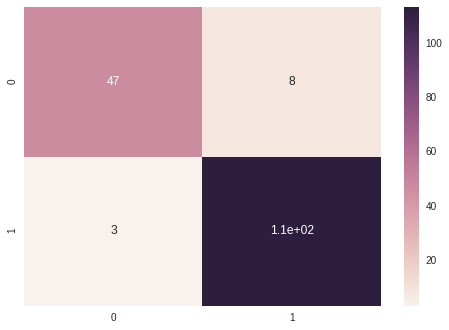

In [4]:
# Generate confusion matrix for the MLP classifier 
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size = 0.3, random_state = seed)


#define the MLP
model = Sequential()
model.add(Dense(16, input_dim=data.shape[1], init = 'uniform', activation='relu'))
model.add(Dropout(0.1)) 
model.add(Dense(32, init = 'uniform', activation='relu'))
model.add(Dropout(0.1)) 
# sigmoid is used here as 2 class problem
model.add(Dense(1, init='uniform', activation='sigmoid')) 
model.compile(loss='binary_crossentropy', optimizer='adam' , metrics=['accuracy'])


print(model.summary())
#model Fit
model.fit(X_train, y_train, batch_size=batch_size, nb_epoch=num_epochs, verbose=0)
# Predicting the Test set results
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)


# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
print("Classification accuracy is {}%".format(((cm[0][0] + cm[1][1])/ y_test.shape[0])*100))

# generate heatmap of the confusion matrix
sns.heatmap(cm, annot=True)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 28, 32)            128       
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 32)            128       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 9, 32)             0         
_________________________________________________________________
activation_1 (Activation)    (None, 9, 32)             0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 9, 32)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 288)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 16)                4624      
__________

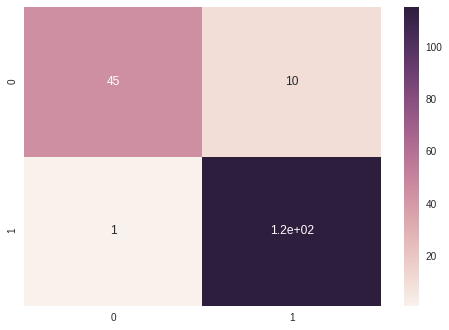

In [5]:
# Employ a 1D CNN model before the linear layers for the same task
model = Sequential()
model.add(Conv1D(32, input_shape=(data.shape[1],1), kernel_size=3, strides=1, padding='valid')),     
model.add(BatchNormalization()), # batch normalization
model.add(MaxPooling1D(3)), 
model.add(Activation('relu')),
model.add(Dropout(0.1)),
model.add(Flatten()),
model.add(Dense(16, init = 'uniform', activation='relu'))
model.add(Dropout(0.1)) 
# softmax is used here as opposed to sigmoid in previous cell as both are
# essentially the same for 2 class problem
model.add(Dense(2, init='uniform', activation='softmax')) 
model.compile(loss='binary_crossentropy', optimizer='adam' , metrics=['accuracy'])

#print model summary
print(model.summary())

#reshape train and test data for the input of CNN
leng =data.shape[1]
X_train = X_train.reshape(X_train.shape[0],  leng,  1).astype('float32')
X_test  = X_test.reshape(X_test.shape[0],  leng,  1).astype('float32')

#model Fit -here one hot encoded y_train is used
model.fit(X_train, np_utils.to_categorical(y_train), batch_size=batch_size, nb_epoch=num_epochs, verbose=0)
# Predicting the Test set results
y_pred = model.predict_classes(X_test)

cm = confusion_matrix(y_test, y_pred)
print("Classification accuracy is {}%".format(((cm[0][0] + cm[1][1])/ y_test.shape[0])*100))
print("AUROC is:", roc_auc_score(y_test, y_pred) )
# generate heatmap of the confusion matrix
sns.heatmap(cm, annot=True)
 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 28, 32)            128       
_________________________________________________________________
batch_normalization_2 (Batch (None, 28, 32)            128       
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 9, 32)             0         
_________________________________________________________________
activation_2 (Activation)    (None, 9, 32)             0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 9, 32)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_24 (Dense)             (None, 16)                528       
__________

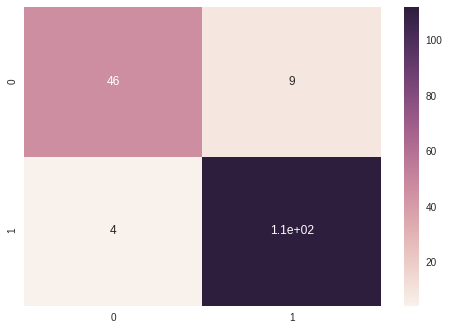

In [6]:
# Employ a 1D CNN-LSTM model before the linear layers for the same task
model = Sequential()
model.add(Conv1D(32, input_shape=(data.shape[1],1), kernel_size=3, strides=1, padding='valid')),                           #Initial layer short kernel focusing on formants
model.add(BatchNormalization()), # batch normalization
model.add(MaxPooling1D(3)), 
model.add(Activation('relu')),
model.add(Dropout(0.1)),
model.add(LSTM(32))#leng,input_shape=(1,leng), return_sequences=True ) )
model.add(Dense(16, init = 'uniform', activation='relu'))
model.add(Dropout(0.1)) 
# softmax is used here  similar to the previous cell
model.add(Dense(2, init='uniform', activation='softmax')) 
model.compile(loss='binary_crossentropy', optimizer='adam' , metrics=['accuracy'])

#print model summary
print(model.summary())

#model Fit -here one hot encoded y_train is used
model.fit(X_train, np_utils.to_categorical(y_train), batch_size=batch_size, nb_epoch=num_epochs, verbose=0)
# Predicting the Test set results
y_pred = model.predict_classes(X_test)

cm = confusion_matrix(y_test, y_pred)
print("Classification accuracy is {}%".format(((cm[0][0] + cm[1][1])/ y_test.shape[0])*100))
print("AUROC is:", roc_auc_score(y_test, y_pred) )
# generate heatmap of the confusion matrix
sns.heatmap(cm, annot=True)
